### <U><B> ACV PROJECT 2 </B> </U>

#### PART-1: FACE RECOGNITION

PROJECT OBJECTIVE: Face Aligned Face Dataset from Pinterest. This dataset contains 10,770 images for 100 people. All images are taken 
from 'Pinterest' and aligned using dlib library. Some data samples


TASK: In this problem, we use a pre-trained model trained on Face recognition to recognise similar faces. Here, we are particularly 
interested in recognising whether two given faces are of the same person or not.


In [1]:
#Import libraries
import os,cv2
%matplotlib inline
import matplotlib.pyplot as plt # Data Visualization
import pandas as pd # Data processing
import seaborn as sns # Data Visualization
import numpy as np # Linear Algebra
import tensorflow as tf #Tensor Flow
import h5py #store huge numeric data
from sklearn import preprocessing #preprocessing libraries from sklearn
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score #metrics from sklearn
import warnings # used to supress display of warnings

from google.colab.patches import cv2_imshow #google colab for cv2.imshow

# suppress display of warnings
warnings.filterwarnings('ignore')

#### 1. Load the dataset and create the metadata.

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#Come to the home directory
%cd /content

/content


In [4]:
#Create a folder for your project e.g in this case, detection. You can choose any name for the folder 
!mkdir face_recognition

#Go to the project folder
%cd face_recognition

/content/face_recognition


In [5]:
from zipfile import ZipFile
with ZipFile('/gdrive/MyDrive/ACV Project 2 Dataset/Dataset Aligned Face Dataset from Pinterest.zip', 'r') as zip:
  zip.extractall()

In [6]:
# Function to load the images from the extracted folder and map each image with person id
class IdentityMetadata():
    def __init__(self, base, name, file):
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

# metadata = load_metadata('images')
metadata = load_metadata('PINS')

In [7]:
print('metadata shape / Total Images:\n', metadata.shape)

metadata shape / Total Images:
 (10770,)


In [8]:
metadata[2000]

PINS/pins_rihanna/rihanna28.jpg

In [9]:
metadata[2000].image_path()

'PINS/pins_rihanna/rihanna28.jpg'

#### 2. Check some samples of metadata.

In [10]:
def show_img(image):
  plt_img = tf.keras.preprocessing.image.load_img(image)
  return plt_img

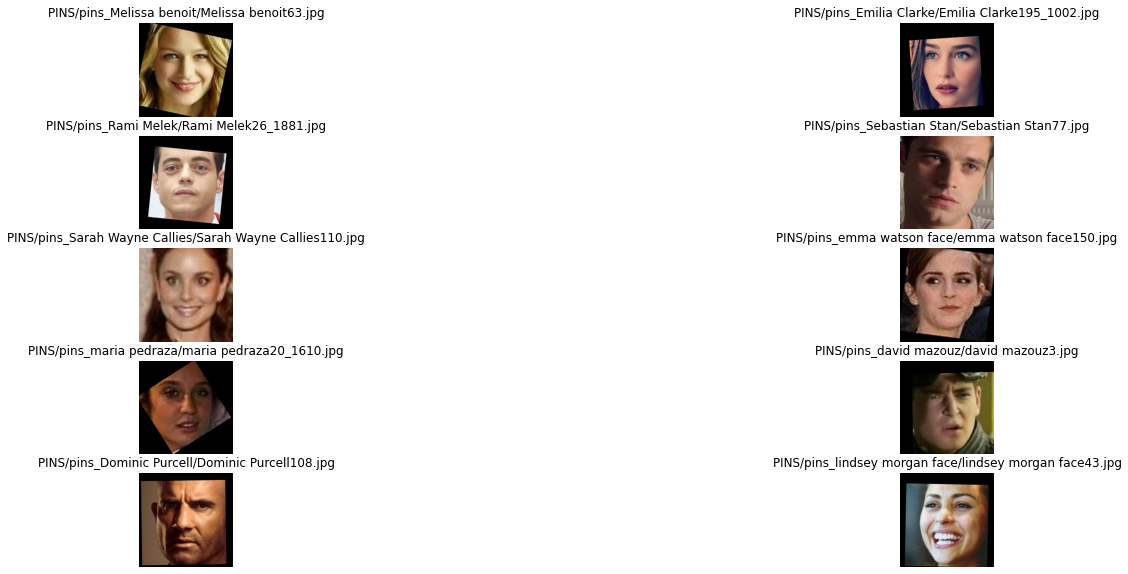

In [11]:
fig = plt.figure(figsize=(25, 10))
for i in range(10):  
    fig.add_subplot(5, 2, i+1)
    img_id = np.random.randint(10770)
    img = metadata[img_id].image_path()
    plt.title(img)
    #print(img)
    img_plt = show_img(img)
    plt.imshow(img_plt)
    plt.axis('off')
plt.show()

In [12]:
IMAGE_HEIGHT= IMAGE_WIDTH = 224
img_id = np.random.randint(10770)
img = metadata[img_id].image_path()
image = show_img(img)
img_array = tf.keras.preprocessing.image.img_to_array(image).astype('uint8')
img_array = (img_array / 255).astype(np.float32)
img = cv2.resize(img_array, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
print(img.shape)

(224, 224, 3)


In [13]:
#define function to load image and resize for input to the model
def input_image(image_id):
  IMAGE_HEIGHT= IMAGE_WIDTH = 224
  #img_id = np.random.randint(10770)
  img = metadata[image_id].image_path()
  img = cv2.imread(img, 1)
  img_array = img[...,::-1] #BGR to RGB
  img_array = (img_array / 255).astype(np.float32)
  img = cv2.resize(img_array, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
  return img

#### 3. Load the pre-trained model and weights.

* vgg_face_weights.h5 is pre-trained model which is been given in the task. So we will use the same. So lets proceed to load the same.

In [14]:
# Define VGG Face Model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [15]:
model = vgg_face()
model.load_weights('/gdrive/MyDrive/ACV Project 2 Dataset/vgg_face_weights.h5')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

#### 4. Generate Embedding vectors for each face in the dataset.

In [17]:
from tensorflow.keras.models import Model
vgg_face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

In [18]:
img_id = np.random.randint(10770)
input_img = input_image(img_id)
embedding_vector = vgg_face_descriptor.predict(np.expand_dims(input_img, axis=0))[0]
print('Shape of embedding vector:',embedding_vector.shape)
embedding_vector

Shape of embedding vector: (2622,)


array([ 0.0073797 , -0.0073613 ,  0.00813611, ..., -0.00711602,
       -0.00506334,  0.00204642], dtype=float32)

In [20]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
  try:
    if i in [100,500,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000]:
      print('Execution loop:',i)
    input_img = input_image(i)
    embedding_vector = vgg_face_descriptor.predict(np.expand_dims(input_img, axis=0))[0]
    embeddings[i]=embedding_vector
  except Exception as e:
    print(str(e))
    print(i,m)
print('Embedding Vector for all vectors captured')

Execution loop: 100
Execution loop: 500
Execution loop: 1000
Execution loop: 2000
Execution loop: 3000
Execution loop: 4000
Execution loop: 5000
Execution loop: 6000
Execution loop: 7000
Execution loop: 8000
Execution loop: 9000
Embedding Vector for all vectors captured


In [21]:
print('embeddings shape :', embeddings.shape)

embeddings shape : (10770, 2622)


In [22]:
np.save('/gdrive/MyDrive/Colab Notebooks/ACV/embeddings_img.npy', embeddings)

#### 5. Build distance metrics for identifying the distance between two given images.

In [23]:
# Define distance metric for distance measrurement between two images embeddings. Used Squared L2 distance
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

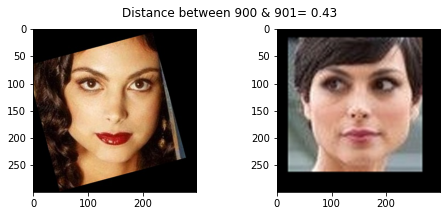

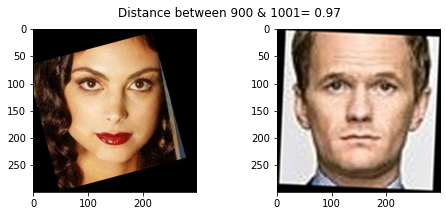

In [25]:
def show_distance(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance between {idx1} & {idx2}= {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(show_img(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(show_img(metadata[idx2].image_path()));    

show_distance(900, 901)
show_distance(900, 1001)

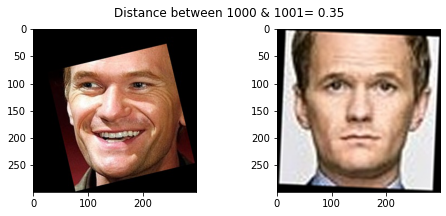

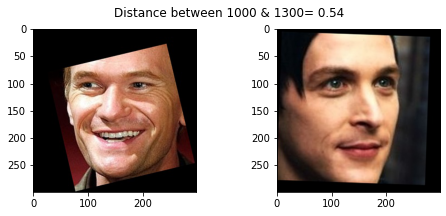

In [26]:
show_distance(1000, 1001)
show_distance(1000, 1300)

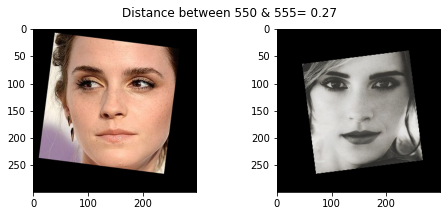

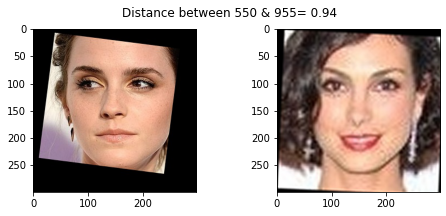

In [42]:
show_distance(550, 555)
show_distance(550, 955)

#### 6. Use PCA for dimensionality reduction.

In [163]:
metadata.itemsize

8

In [164]:
# Defining train and test sets
train_idx = np.arange(metadata.shape[0]) % 9 != 0     #every 9th example goes in test data and rest go in train data
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

In [165]:
print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [166]:
y_train[500], y_test[100]

('pins_emma watson face', 'pins_Morena Baccarin')

In [167]:
#get unique labels count in train and test
len(np.unique(y_test)), len(np.unique(y_train))

(100, 100)

In [168]:
# Standarize features data using standard scaler
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [169]:
# Encoding the labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

In [170]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128, svd_solver='randomized', whiten=True)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#### 7. Build an SVM classifier to map each image to its right person.

In [70]:
# Use SVM classifier model
from sklearn.svm import SVC

clf = SVC(kernel='rbf', class_weight=None , C=10000000, gamma='auto')
clf.fit(X_train_pca, y_train_encoded)
print('Classifier Score: %2.3f' %(clf.score(X_test_pca, y_test_encoded)*100))


Classifier Score: 95.906



#### 8. Predict using the SVM model.

Actual Image is of: emma watson face


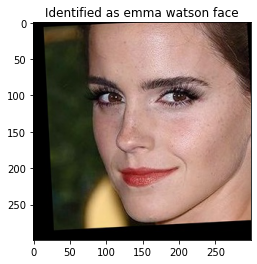

In [188]:
sample_idx = 60
sample_image = show_img(metadata[test_idx][sample_idx].image_path())
print('Actual Image is of:', metadata[test_idx][sample_idx].name[5:])
prediction = clf.predict([X_test_pca[sample_idx]])
sample_identity = encoder.inverse_transform(prediction)[0]
sample_identity = sample_identity[5:]
plt.imshow(sample_image)
plt.title(f'Identified as {sample_identity}');

Actual Image is of: mark zuckerberg


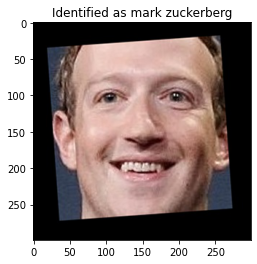

In [189]:
sample_idx = 1
sample_image = show_img(metadata[test_idx][sample_idx].image_path())
print('Actual Image is of:', metadata[test_idx][sample_idx].name[5:])
prediction = clf.predict([X_test_pca[sample_idx]])
sample_identity = encoder.inverse_transform(prediction)[0]
sample_identity = sample_identity[5:]
plt.imshow(sample_image)
plt.title(f'Identified as {sample_identity}');

Actual Image is of: Alvaro Morte


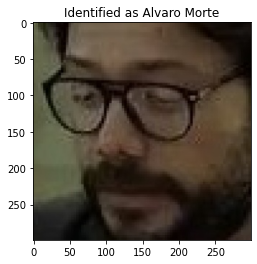

In [190]:
sample_idx = 9
sample_image = show_img(metadata[test_idx][sample_idx].image_path())
print('Actual Image is of:', metadata[test_idx][sample_idx].name[5:])
prediction = clf.predict([X_test_pca[sample_idx]])
sample_identity = encoder.inverse_transform(prediction)[0]
sample_identity = sample_identity[5:]
plt.imshow(sample_image)
plt.title(f'Identified as {sample_identity}');

#### PART-2: Vehicle traffic Density

PROJECT OBJECTIVE: Detect vehicles on traffic video file and impute bounding box around the vehicle

In [191]:
clf_path = '/gdrive/MyDrive/Colab Notebooks/ACV/cars.xml'
video_file_1 = '/gdrive/MyDrive/ACV Project 2 Dataset/video1.mp4'
video_file_2 = '/gdrive/MyDrive/ACV Project 2 Dataset/video2.mp4'

In [200]:
import time

car_classifier = cv2.CascadeClassifier(clf_path) # use opencv classifier for detecting car
cap = cv2.VideoCapture(video_file_1) # capture video file in opencv object
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
   
# Below VideoWriter object will create
# a frame of above defined The output 
# is stored in 'filename.avi' file.
out = cv2.VideoWriter('video1_result.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

# Loop for each frame in the video
while cap.isOpened():
    
    time.sleep(.05)
    # Read first frame
    ret, frame = cap.read()
    if ret:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      # Pass frame to our car classifier
      cars = car_classifier.detectMultiScale(frame, 1.1, 2)
      for (x,y,w,h) in cars:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
      
      result = np.asarray(frame)
      result = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      out.write(result)
      
    else:
      print('Video has ended or failed, try a different video format!')
      break
    if cv2.waitKey(0)== 1:
        break
cap.release()
out.release()
cv2.destroyAllWindows()

Video has ended or failed, try a different video format!


In [201]:
%cp '/content/face_recognition/video1_result.avi' '/gdrive/MyDrive/Colab Notebooks/ACV/'

In [202]:
import time

car_classifier = cv2.CascadeClassifier(clf_path) # use opencv classifier for detecting car
cap = cv2.VideoCapture(video_file_2) # capture video file in opencv object
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
size = (frame_width, frame_height)
   
# Below VideoWriter object will create
# a frame of above defined The output 
# is stored in 'filename.avi' file.
out = cv2.VideoWriter('video2_result.avi', 
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

# Loop for each frame in the video
while cap.isOpened():
    
    time.sleep(.05)
    # Read first frame
    ret, frame = cap.read()
    if ret:
      frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      # Pass frame to our car classifier
      cars = car_classifier.detectMultiScale(frame, 1.1, 2)
      for (x,y,w,h) in cars:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
      
      result = np.asarray(frame)
      result = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
      out.write(result)
      
    else:
      print('Video has ended or failed, try a different video format!')
      break
    if cv2.waitKey(0)== 1:
        break
cap.release()
out.release()
cv2.destroyAllWindows()

Video has ended or failed, try a different video format!


In [203]:
%cp '/content/face_recognition/video2_result.avi' '/gdrive/MyDrive/Colab Notebooks/ACV/'

* Although cv2 car classifier is not that accurate still able to detect most of the vehicles

### THANK YOU